# 3. 1D Cartesian structured VDS along  parallel lines

In this notebook, we perform pseudo-random variable density sampling along the phase encoding direction.
A handcrafted density is designed and samples are then drawn by virtually
inverting its cumulative density function. Then these samples define the
selected phase encoding lines retained in the sampling mask. Low frequencies
are more sampled than higher frequencies.

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 06/24/2022
- Date : 04/02/2025 (use of BrainWeb database using multi-contrast T1/T2/etc imaging)
- Target: [IEEE EMBS-SPS Summer School](http://conferences.imt-atlantique.fr/ieeess/index.php?pid=1) on **Novel acquisition and image reconstruction strategies in accelerated Magnetic Resonance Imaging**

(256, 256)


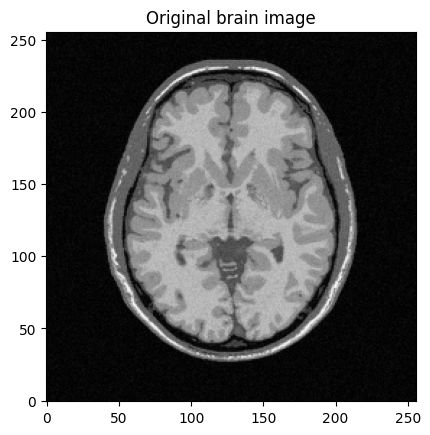

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters

import pywt as pw
import matplotlib.pyplot as plt

import brainweb_dl as bwdl

plt.rcParams["image.origin"]="lower"
plt.rcParams["image.cmap"]='Greys_r'

mri_img = bwdl.get_mri(4, "T1")[70, ...].astype(np.float32)
#mri_img = bwdl.get_mri(4, "T2")[120, ...].astype(np.float32)
print(mri_img.shape)
img_size = mri_img.shape[0]
plt.figure()
plt.imshow(abs(mri_img))
plt.title("Original brain image")
plt.show()


64
[127 179 116 248 126 124 122 127 128 127 127 127  52 122 191 127 117 128
 146 128 220 172 127 125 127 114 131 127 125 113 126  86 125  64 124 145
  16 128 156 127 127  76 126 123 148 127 127 127 127 153 180 115 118  69
 127 126 197 126 127 136  68 231 125 107]


/tmp/ipykernel_217874/2994268964.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]


<Figure size 640x480 with 0 Axes>

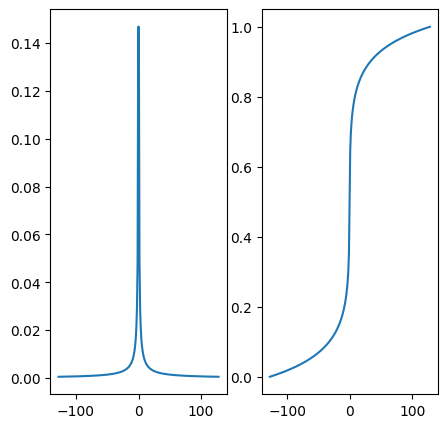

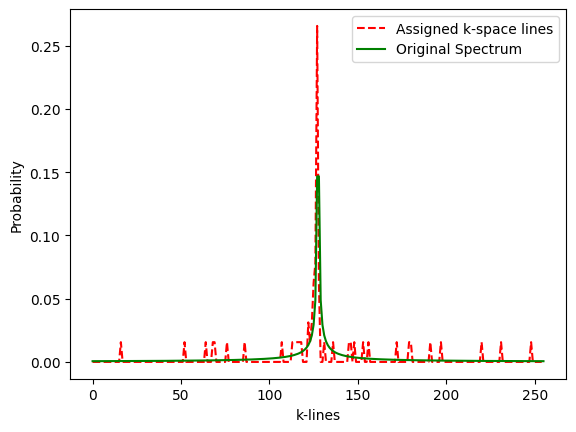

[ 16  52  64  68  69  76  86 107 113 114 115 116 117 118 122 123 124 125
 126 127 128 131 136 145 146 148 153 156 172 179 180 191 197 220 231 248]
36


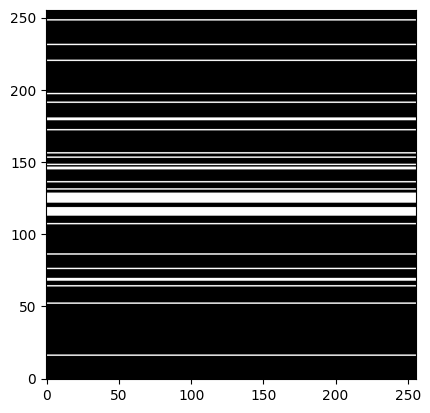

In [2]:
import numpy as np
import sys
import numpy.random as ra

eps = sys.float_info.epsilon

c = np.ones((1, img_size), dtype="float64")
kspace_mask = np.tile(c, (img_size, 1))
#kspace_lines = np.linspace(-1/2., 1/2.,img_size)
kspace_lines = np.linspace(-1/2., 1/2.,img_size)*img_size
# define the taret sampling density (ie non-iniform over k-space lines)
decay = 1.
# Define the sampling density
p_decay = np.power(np.abs(kspace_lines),-decay)
p_decay = p_decay/np.sum(p_decay)
# generate its CDF
cdf_pdecay = np.cumsum(p_decay)


pmax = p_decay.max()
pmin = p_decay.min()

# Plot the density and its cumulative distribution function (CDF) p_decay
plt.figure()
fig, axs = plt.subplots(1, 2, figsize= (5,5) )
axs[0].plot(kspace_lines, p_decay)
axs[1].plot(kspace_lines, cdf_pdecay)

# Perform pseudo-random sampling: technique used:
# draw uniform variables and invert the CDF to get back to p_decay-distributed sampled
nb_samples = (int)(img_size/4)
print(nb_samples)
samples = ra.uniform(0, 1, nb_samples)
gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]

# shift the samples lines by half of the k-space (ie image size as we're in Cartesian ref)
gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int) + (int)(img_size/2)
#gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int)
print(gen_klinesb)   # unsorted samples
times = np.arange(1, img_size, 1)
lc = np.bincount(gen_klinesb, minlength=len(times))

# check that histogram of sample values fits the prescribed density p_decay
plt.figure()
plot1, = plt.plot(lc/float(sum(lc)), 'r--', label='Assigned k-space lines')
plot2, = plt.plot(p_decay,'g',label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()


#print(p_decay.min())
sampled_klines = np.array(np.unique(gen_klinesb))
print(sampled_klines)

nblines = np.size(sampled_klines)
print(nblines)
threshold = 2. * p_decay.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask[sampled_klines,:] = np.ones((nblines,img_size) , dtype="float64")

plt.figure()
plt.imshow(kspace_mask, cmap='gray')
plt.show()

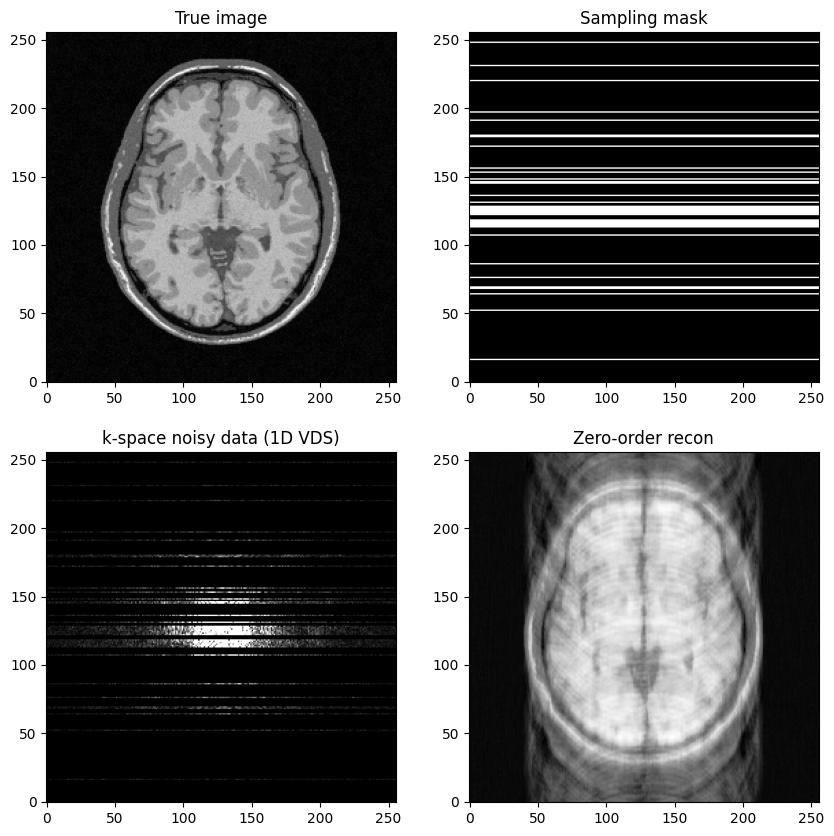

In [3]:
#import numpy.fft as fft
norm = "ortho"
#norm = None
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)


# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
#kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Simulate independent noise realization on the real & imag parts
kspace_data += (np.random.randn(*mri_img.shape) + 1j * np.random.randn(*mri_img.shape)) * signoise

# Mask data to perform subsampling
kspace_data *= kspace_mask

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask, cmap='gray')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.005*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (1D VDS)")
axs[1,1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()